In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%load_ext tensorboard

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
import os
import datetime
warnings.filterwarnings('ignore')

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import tensorflow as tf

from xgboost import XGBRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [4]:
df_solar = pd.read_csv("/content/drive/MyDrive/luminous-files/solar.csv")
df_solar['datetime'] = pd.to_datetime(df_solar['datetime'], dayfirst = True)

In [5]:
df_solar.dtypes

,0
Unnamed: 0,int64
datetime,datetime64[ns]
WindSpeed,float64
Sunshine,int64
AirPressure,float64
Radiation,float64
AirTemperature,float64
RelativeAirHumidity,int64
SystemProduction,float64
Unnamed: 9,float64


In [6]:
df_solar = df_solar.drop(columns = ['Unnamed: 0', 'Unnamed: 9'], axis = 1)

In [7]:
df_solar.sample(5)

,datetime,WindSpeed,Sunshine,AirPressure,Radiation,AirTemperature,RelativeAirHumidity,SystemProduction
1542,2017-03-06 06:00:00,5.8,0,1018.0,-4.6,-3.5,67,0.0000
3459,2017-05-25 03:00:00,1.6,0,1016.4,-7.6,10.3,64,0.0000
8618,2017-12-26 02:00:00,3.7,0,992.3,-6.2,0.4,84,0.0000
7214,2017-10-28 14:00:00,4.0,53,991.6,248.5,12.4,38,559.6667
992,2017-02-11 08:00:00,4.6,0,1042.8,-4.8,-3.0,78,0.0000


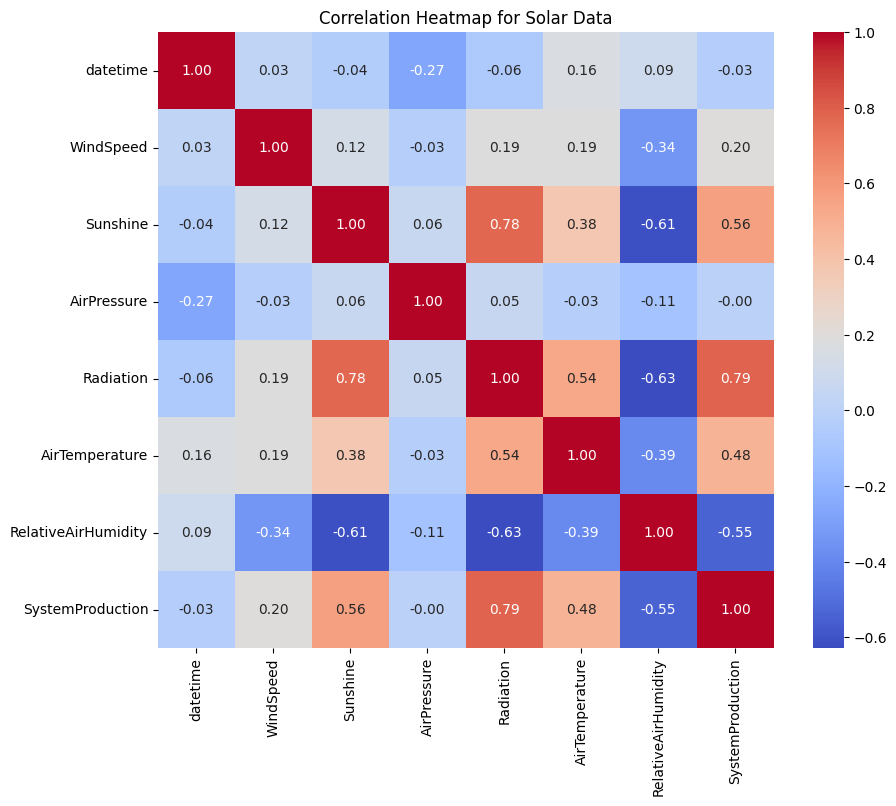

In [8]:
plt.figure(figsize=(10, 8))
sns.heatmap(df_solar.corr(), annot=True, fmt=".2f", cmap="coolwarm", cbar=True, square=True)
plt.title("Correlation Heatmap for Solar Data")
plt.show()

In [9]:
df_solar = df_solar.drop(columns = ['AirPressure'], axis = 1)
df_solar

,datetime,WindSpeed,Sunshine,Radiation,AirTemperature,RelativeAirHumidity,SystemProduction
0,2017-01-01 00:00:00,0.6,0,-7.4,0.1,97,0.0
1,2017-01-01 01:00:00,1.7,0,-7.4,-0.2,98,0.0
2,2017-01-01 02:00:00,0.6,0,-6.7,-1.2,99,0.0
3,2017-01-01 03:00:00,2.4,0,-7.2,-1.3,99,0.0
4,2017-01-01 04:00:00,4.0,0,-6.3,3.6,67,0.0
...,...,...,...,...,...,...,...
8755,2017-12-31 19:00:00,4.1,0,-4.8,-0.7,94,0.0
8756,2017-12-31 20:00:00,2.1,0,-5.0,-0.3,95,0.0
8757,2017-12-31 21:00:00,1.8,0,-5.3,0.2,93,0.0
8758,2017-12-31 22:00:00,2.2,0,-5.4,0.3,92,0.0


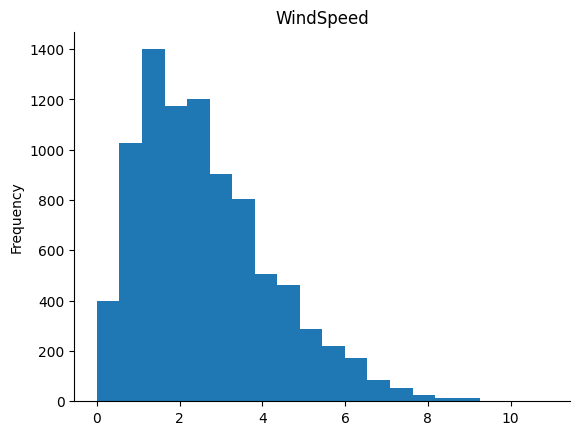

In [10]:
# @title WindSpeed

from matplotlib import pyplot as plt
df_solar['WindSpeed'].plot(kind='hist', bins=20, title='WindSpeed')
plt.gca().spines[['top', 'right',]].set_visible(False)

In [11]:
df_solar.describe().T

,count,mean,min,25%,50%,75%,max,std
datetime,8760,2017-07-02 11:30:00,2017-01-01 00:00:00,2017-04-02 05:45:00,2017-07-02 11:30:00,2017-10-01 17:15:00,2017-12-31 23:00:00,NaN
WindSpeed,8760.0,2.639823,0.0,1.4,2.3,3.6,10.9,1.628754
Sunshine,8760.0,11.180479,0.0,0.0,0.0,7.0,60.0,21.171295
Radiation,8760.0,97.538493,-9.3,-6.2,-1.4,115.6,899.7,182.336029
AirTemperature,8760.0,6.978893,-12.4,0.5,6.4,13.4,27.1,7.604266
RelativeAirHumidity,8760.0,76.719406,13.0,64.0,82.0,93.0,100.0,19.278996
SystemProduction,8760.0,684.746071,0.0,0.0,0.0,464.24995,7701.0,1487.454665


In [12]:
df_solars = df_solar.copy()

In [13]:
df_solars = df_solars.set_index('datetime')
df_solars.head()

,WindSpeed,Sunshine,Radiation,AirTemperature,RelativeAirHumidity,SystemProduction
datetime,,,,,,
2017-01-01 00:00:00,0.6,0,-7.4,0.1,97,0.0
2017-01-01 01:00:00,1.7,0,-7.4,-0.2,98,0.0
2017-01-01 02:00:00,0.6,0,-6.7,-1.2,99,0.0
2017-01-01 03:00:00,2.4,0,-7.2,-1.3,99,0.0
2017-01-01 04:00:00,4.0,0,-6.3,3.6,67,0.0


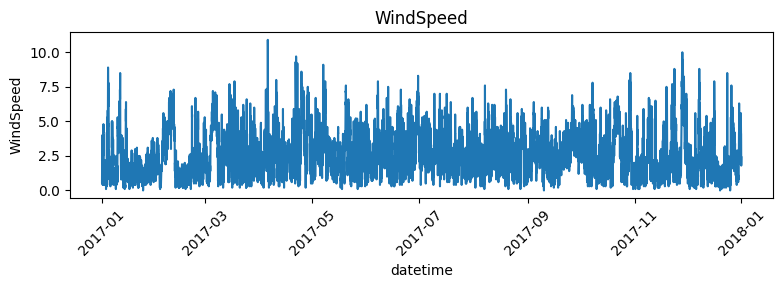

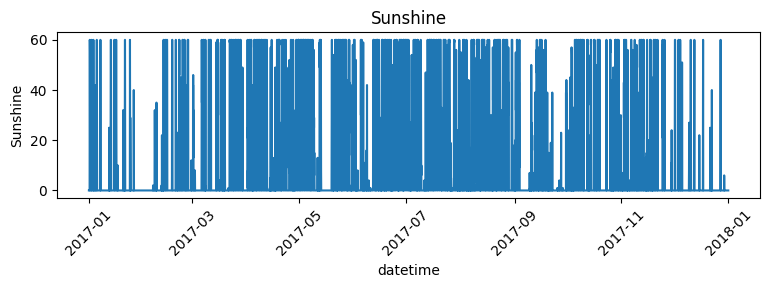

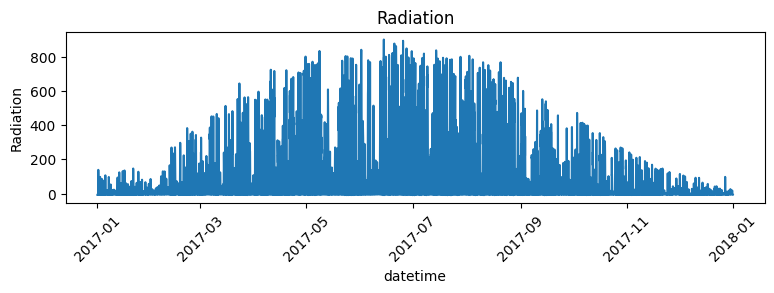

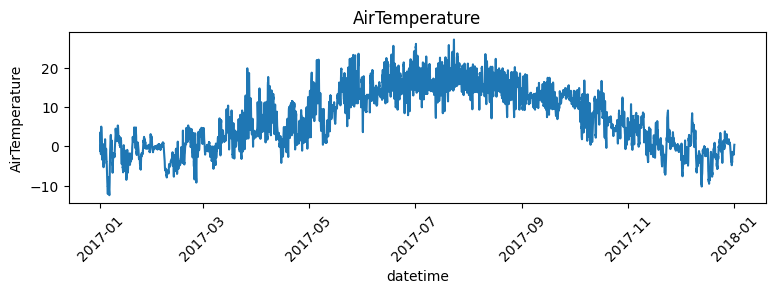

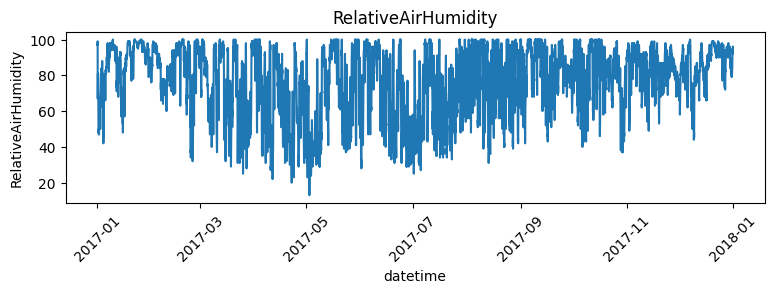

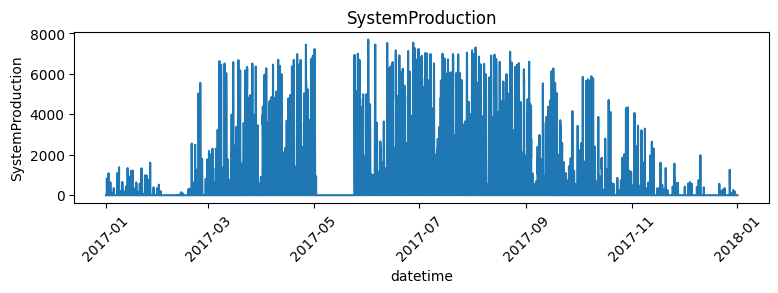

In [14]:
vars = ['WindSpeed', 'Sunshine', 'Radiation', 'AirTemperature', 'RelativeAirHumidity', 'SystemProduction']
for i,v in enumerate(vars):
  plt.figure(figsize = (15, 10))
  plt.subplot(4,2, i+1)
  sns.lineplot(data=df_solars[v])
  plt.title(v)
  plt.xlabel('datetime')
  plt.ylabel(v)
  plt.xticks(rotation=45)
  plt.tight_layout()
  plt.show()

In [15]:
def create_features(df):
    '''create time series features from the index '''

    df['hour'] = df.index.hour
    df['day_of_week'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['day_of_month'] = df.index.day
    df['day_of_year'] = df.index.dayofyear
    df['week_of_year'] = df.index.isocalendar().week
    df['year'] = df.index.year

    return df
create_features(df_solars)
df_solars.head()

,WindSpeed,Sunshine,Radiation,AirTemperature,RelativeAirHumidity,SystemProduction,hour,day_of_week,quarter,month,day_of_month,day_of_year,week_of_year,year
datetime,,,,,,,,,,,,,,
2017-01-01 00:00:00,0.6,0,-7.4,0.1,97,0.0,0,6,1,1,1,1,52,2017
2017-01-01 01:00:00,1.7,0,-7.4,-0.2,98,0.0,1,6,1,1,1,1,52,2017
2017-01-01 02:00:00,0.6,0,-6.7,-1.2,99,0.0,2,6,1,1,1,1,52,2017
2017-01-01 03:00:00,2.4,0,-7.2,-1.3,99,0.0,3,6,1,1,1,1,52,2017
2017-01-01 04:00:00,4.0,0,-6.3,3.6,67,0.0,4,6,1,1,1,1,52,2017


In [16]:
df_train = df_solars.loc[df_solars.index < '2017-10-15']
df_test = df_solars.loc[df_solars.index >= '2017-10-15']

In [17]:
X_train = df_train.drop(columns = ['SystemProduction'], axis = 1)
y_train = df_train['SystemProduction']

In [18]:
X_test = df_test.drop(columns = ['SystemProduction'], axis = 1)
y_test = df_test['SystemProduction']

In [19]:
params = {
    'max_depth': [2, 4, 6, 8, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4, 6],
    'max_features': [None, 'sqrt', 'log2'],
    'splitter': ['best', 'random'],
    'criterion': ['mse', 'friedman_mse', 'mae'],
}

In [20]:
xgb = DecisionTreeRegressor()
grid = GridSearchCV(xgb, params, n_jobs = -1, scoring = 'neg_mean_squared_error')
grid.fit(X_train, y_train)

GridSearchCV(estimator=DecisionTreeRegressor(), n_jobs=-1,
             param_grid={'criterion': ['mse', 'friedman_mse', 'mae'],
                         'max_depth': [2, 4, 6, 8, 10],
                         'max_features': [None, 'sqrt', 'log2'],
                         'min_samples_leaf': [1, 2, 4, 6],
                         'min_samples_split': [2, 5, 10],
                         'splitter': ['best', 'random']},
             scoring='neg_mean_squared_error')

In [21]:
grid.best_params_

{'criterion': 'friedman_mse',
 'max_depth': 4,
 'max_features': None,
 'min_samples_leaf': 1,
 'min_samples_split': 5,
 'splitter': 'best'}

In [22]:
y_pred = grid.predict(X_test)

In [23]:
X_test.shape

(1872, 13)

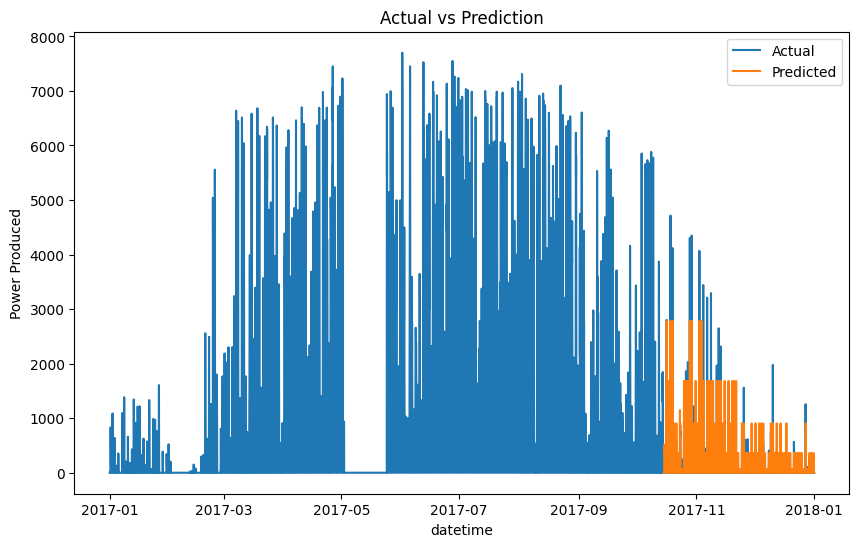

In [24]:
plt.figure(figsize=(10, 6))
sns.lineplot(x=df_solars.index, y='SystemProduction', data=df_solars, label='Actual')
sns.lineplot(x=X_test.index, y=y_pred, label='Predicted')

plt.title('Actual vs Prediction')
plt.ylabel('Power Produced')
plt.xlabel('datetime')
plt.show()

In [25]:
grid

GridSearchCV(estimator=DecisionTreeRegressor(), n_jobs=-1,
             param_grid={'criterion': ['mse', 'friedman_mse', 'mae'],
                         'max_depth': [2, 4, 6, 8, 10],
                         'max_features': [None, 'sqrt', 'log2'],
                         'min_samples_leaf': [1, 2, 4, 6],
                         'min_samples_split': [2, 5, 10],
                         'splitter': ['best', 'random']},
             scoring='neg_mean_squared_error')

In [26]:
X_test.shape

(1872, 13)

In [27]:
X_test.iloc[23].T

,2017-10-15 23:00:00
WindSpeed,4.2
Sunshine,0.0
Radiation,-6.4
AirTemperature,13.2
RelativeAirHumidity,100.0
hour,23.0
day_of_week,6.0
quarter,4.0
month,10.0
day_of_month,15.0


In [28]:
np.array([2,0,15.9,9.9,84,0,13.0,6,4,10,15,288,41,2017]).shape

(14,)

In [29]:
grid.predict(np.array([4.2,0.0,-6.4,13.2,100.0,23.0,6.0,4.0,10.0,15.0,288.0,41.0,2017.0]).reshape(1, -1))

array([1.85333447])